<a href="https://colab.research.google.com/github/ilinashah177/Coursework-Website/blob/main/Phase_3_Multiple_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Draw graphs "inline" in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np
#Make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

In [2]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Dataset Group14 Coursework(AutoRecovered) 4.csv to Dataset Group14 Coursework(AutoRecovered) 4.csv


In [5]:
#Name of uploaded file
file_name = 'Dataset Group14 Coursework(AutoRecovered) 4.csv'

#Read data from the required sheet
df = pd.read_csv('Dataset Group14 Coursework(AutoRecovered) 4.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df.head()

,Year,TECA,Access to electricity (% of population),GDP Growth (annual %),Total Population,Consumption,BRI Investments in Energy Sector (USD millions)
0,2015.0,400.0,91.0,4.2,"217,290,883","85,818",520.40
1,2016.0,650.0,91.8,6.6,"220,138,869","90,431",893.25
2,2017.0,1469.0,92.7,4.4,"223,273,967","95,529",2296.00
3,2018.0,1420.0,93.4,6.2,"226,928,892","106,928",2062.00
4,2019.0,1980.0,93.9,2.5,"230,800,899","109,461",2907.00


In [6]:
#Generate summary statistics, and round everything to 2 decimal places
summary=df.describe().round(2)
summary

,Year,TECA,Access to electricity (% of population),GDP Growth (annual %),BRI Investments in Energy Sector (USD millions)
count,8.00,8.00,8.00,8.00,8.00
mean,2018.50,1500.00,93.40,4.24,1831.58
std,2.45,1138.49,1.47,2.63,835.88
min,2015.00,400.00,91.00,-1.30,520.40
25%,2016.75,688.25,92.48,3.78,1423.31
50%,2018.50,1400.00,93.65,4.60,1860.00
75%,2020.25,1596.75,94.60,6.28,2401.00
max,2022.00,4000.00,95.00,6.60,2907.00


In [7]:
df['Total Population'] = df['Total Population'].astype(str).str.replace(',', '', regex=False).astype(float)
df['Consumption'] = df['Consumption'].astype(str).str.replace(',', '', regex=False).astype(float)
df['BRI Investments in Energy Sector (USD millions)'] = df['BRI Investments in Energy Sector (USD millions)'].astype(str).str.replace(',', '', regex=False).astype(float)

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

#Define outliers as data points outside of Q1 - 1.5*IQR or Q3 + 1.5*IQR
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)

#Remove outliers
data_cleaned = df[~outliers]

In [8]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(data_cleaned, list_var_not_to_remove=None, thresh=5):
    # Initialize df with data_cleaned to ensure it's defined
    df = data_cleaned.copy()

    # Replace infinite values with NaN
    df = df.replace([np.inf, -np.inf], np.nan)

    # Drop rows with any missing values
    df = df.dropna()

    while True:
        #Adding a constant item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        #Drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        #Drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        #If the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            #If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            #No VIF is above threshold, exit the loop
            break

    return df

In [9]:
predictor_vars=['GDP Growth (annual %)', 'Total Population', 'BRI Investments in Energy Sector (USD millions)']

vif = drop_column_using_vif_(data_cleaned[predictor_vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 3.3515539529896747
The columns remaining after VIF selection are:
Index(['GDP Growth (annual %)', 'Total Population',
       'BRI Investments in Energy Sector (USD millions)'],
      dtype='object')


Text(0.5, 1.0, 'Correlation Matrix')

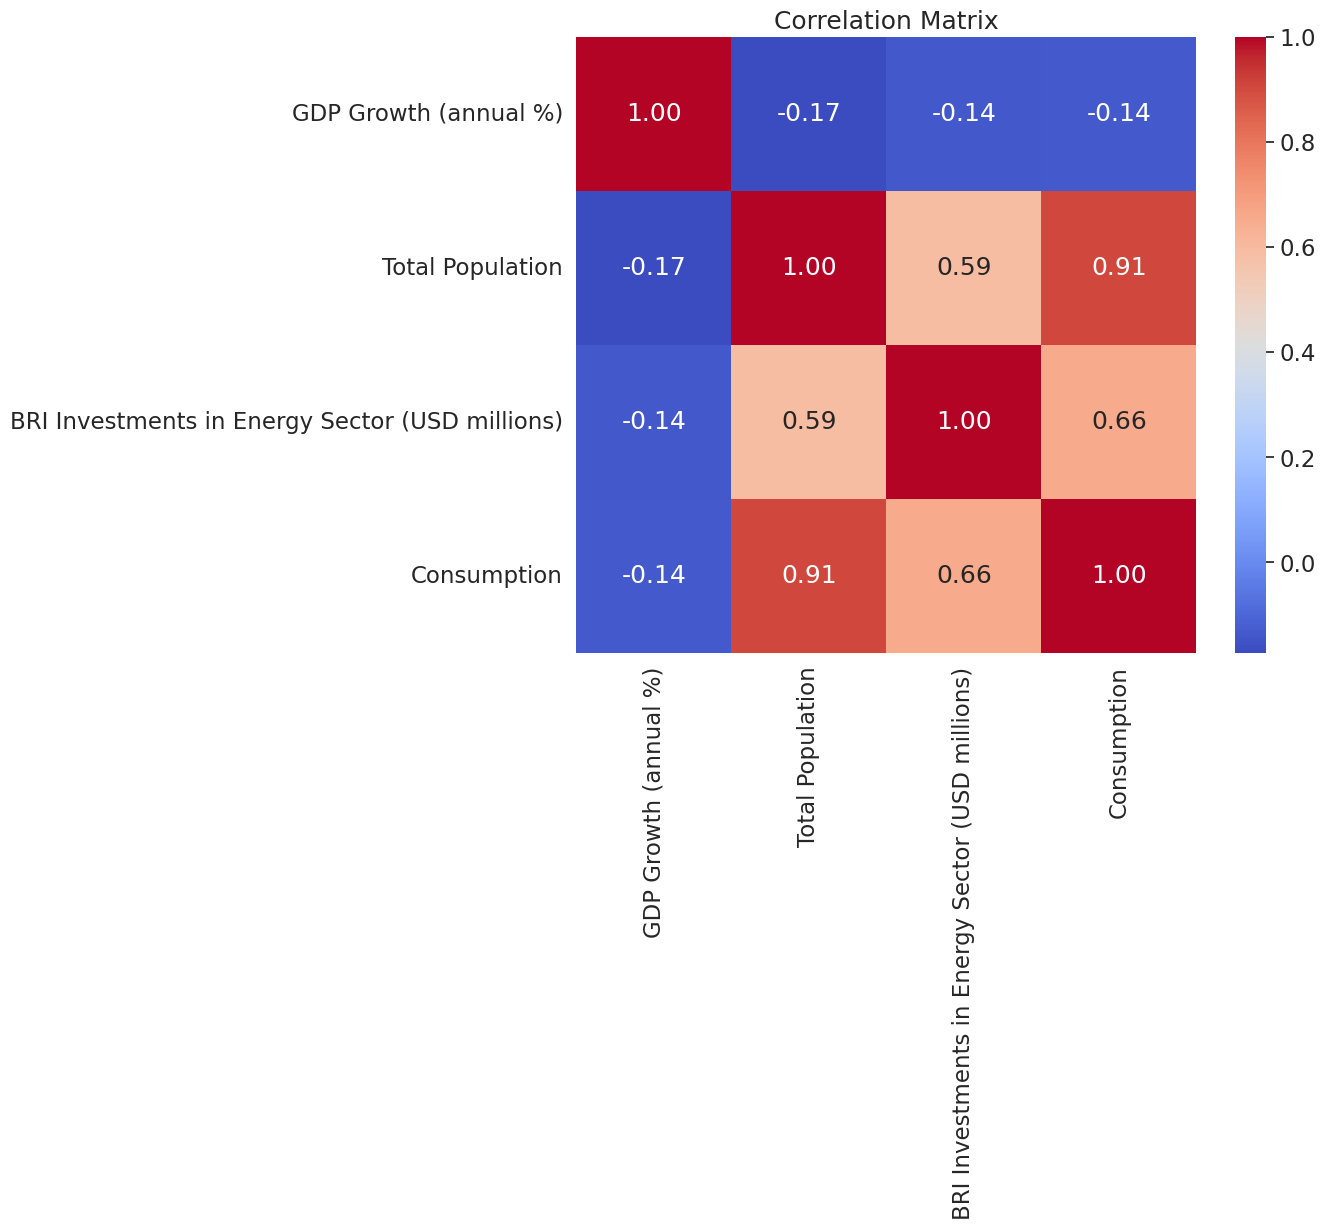

In [10]:
df['Total Population'] = df['Total Population'].astype(str).str.replace(',', '').astype(float)
df['Consumption'] = df['Consumption'].astype(str).str.replace(',', '').astype(float) #Fixed typo in column name from 'Consumption)' to 'Consumption'

sns.heatmap(df[['GDP Growth (annual %)', 'Total Population', 'BRI Investments in Energy Sector (USD millions)','Consumption']].corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [11]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

model2_sm = ols('Consumption ~ Q("GDP Growth (annual %)") + Q("Total Population") + Q("BRI Investments in Energy Sector (USD millions)")', data=df).fit()
print(model2_sm.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     7.274
Date:                Fri, 17 Jan 2025   Prob (F-statistic):             0.0426
Time:                        19:05:01   Log-Likelihood:                -77.836
No. Observations:                   8   AIC:                             163.7
Df Residuals:                       4   BIC:                             164.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


In [12]:
print('The t-statistic for BRI investments in this regression model is 0.776')
print('The p-value for this regression model is 0.481')
print('As the p-value is greater than 0.05, the multiple regression shows that when holding GDP Growth and Total Population constant, there is not a significant relationship between BRI Investments and Energy Consumption.')


The t-statistic for BRI investments in this regression model is 0.776
The p-value for this regression model is 0.481
As the p-value is greater than 0.05, the multiple regression shows that when holding GDP Growth and Total Population constant, there is not a significant relationship between BRI Investments and Energy Consumption.
